<h2 style="color:darkmagenta; font-family:Cursive"><center><b>Customer Segmentation</center></h2> 
    
<img src="https://img2.storyblok.com/1120x292/filters:format(webp)/f/47007/2400x626/36e957bd2b/221005_customersegmentation_blog_teaser_v01.png" alt="Customer Segmentation" class="center">

<h2 style="color:MediumVioletRed; font-family:Cursive"><b>About the data💡</h2>

* This dataset consists of 1 Million+ transaction by over 800K customers for a bank in India.
* The data contains information such as - customer age (DOB), location, gender, account balance at the time of the transaction , transactiondetails,transaction amount, etc.  

<h2 style="color:MediumVioletRed; font-family:Cursive"><b>Goal of creating this Notebook🎯</h2>

1. Perform Clustering / Segmentation on the dataset and identify popular customer groups along with their definitions/rules
2. Perform Location-wise analysis to identify regional trends in India
3. Perform transaction-related analysis to identify interesting trends that can be used by a bank to improve / optimi their user experiences
4. Customer Recency, Frequency, Monetary analysis
5. Network analysis or Graph analysis of customer data.

**Table of contents of this notebook: 📭**

1. [Importing Necessary Libraries](#1)

2. [Data Collection](#2)

3. [Data Cleaning](#3)

4. [Exploratory Data Analysis](#4)

5. [Feature Engineering](#5)

6. [Modelling](#6)

<h2  style="color:darkmagenta;text-align: center; background-color: AliceBlue;padding: 20px;">1. Importing Libraries</h2><a id = "1"></a>

In [1]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns
try:
    import plotly.express as px
    import plotly.graph_objects as go

except:
    !pip install plotly
    import plotly.express as px
    import plotly.graph_objects as go


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import scipy.cluster.hierarchy as sch
from sklearn. preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

try:
    from kneed import KneeLocator
except:
    !pip install kneed
    from kneed import KneeLocator
#------------------------------------------------------------------
try:
    from yellowbrick.cluster import KElbowVisualizer
except:
    !pip install -U yellowbrick
    from yellowbrick.cluster import KElbowVisualizer


/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


<h2  style="color:darkmagenta;text-align: center; background-color: AliceBlue;padding: 20px;">2. Data Collection</h2><a id = "2"></a>

In [2]:
df=pd.read_csv("/kaggle/input/bank-customer-segmentation/bank_transactions.csv")
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [3]:
df.shape

(1048567, 9)

<p style="color:DarkSlateGray"> wow, the shape of the data is very big 😵😵</p>

<h2  style="color:darkmagenta;text-align: center; background-color: AliceBlue;padding: 20px;">3. Data Cleaning</h2><a id = "3"></a>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [5]:
## Show detailes data set
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check 
check(df)

,column,dtypes,nunique,sum_null
0,TransactionID,object,1048567,0
1,CustomerID,object,884265,0
2,CustomerDOB,object,17254,3397
3,CustGender,object,3,1100
4,CustLocation,object,9355,151
5,CustAccountBalance,float64,161328,2369
6,TransactionDate,object,55,0
7,TransactionTime,int64,81918,0
8,TransactionAmount (INR),float64,93024,0


In [6]:
# delete missing data
df.dropna(inplace=True)

In [7]:
#check for duplication
df.duplicated().sum()

0

In [8]:
# convert type of columns TransactionDate,CustomerDOB from string to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])

<p> calculate customer age :</p>
<p> CustomerDOB is the birth date of the customer , TransactionDate : is the date of transaction that customer is done
</p>

In [9]:
df['CustomerAge'] =df['TransactionDate'].dt.year - df['CustomerDOB'].dt.year

<p>I will delete TransactionTime because I do not know what is Transaction of Time. ,and this time  indicates for what days or hours or minutes 🤷‍ </p>

In [10]:
df.drop(columns=['TransactionTime'],inplace=True)

In [11]:
df.CustGender.value_counts()

M    760978
F    280635
T         1
Name: CustGender, dtype: int64

In [12]:
df.drop(df[df['CustGender']=='T'].index,inplace=True)

In [13]:
num_col = df.select_dtypes(include=np.number)
cat_col = df.select_dtypes(exclude=np.number)

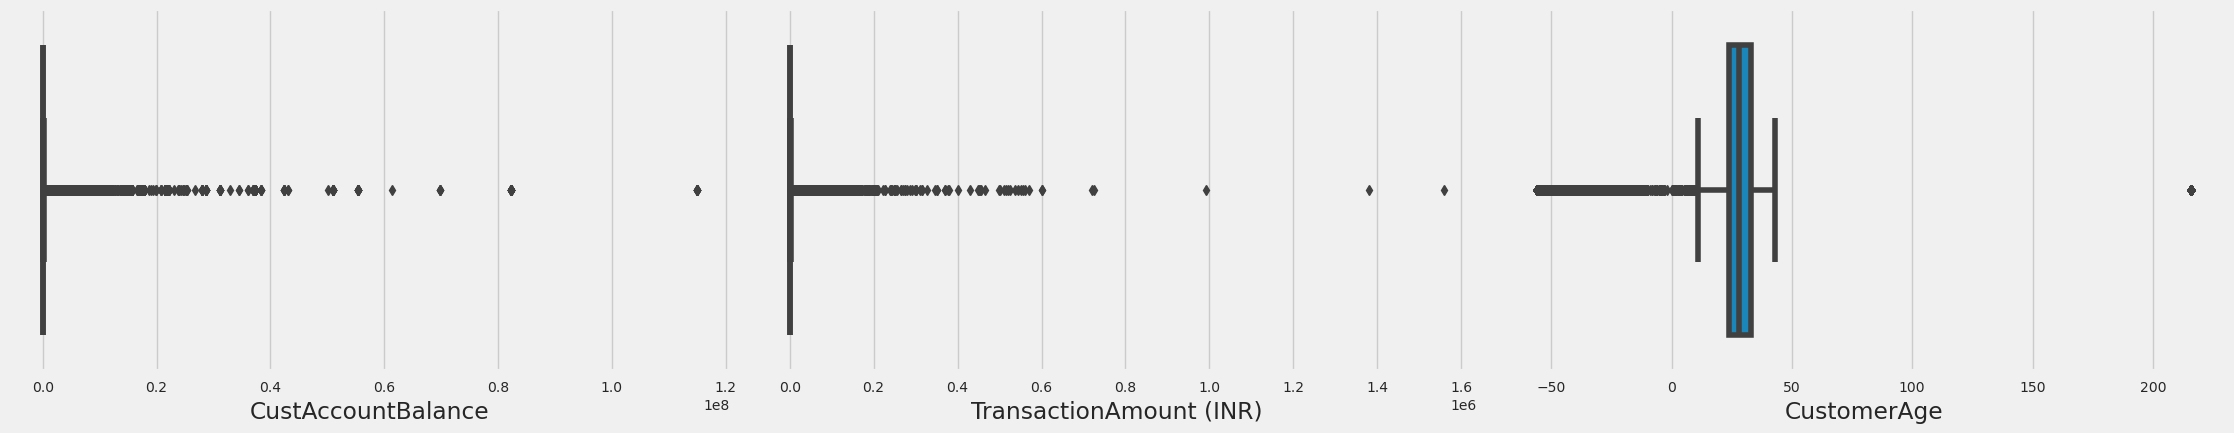

In [14]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(30,30))
for index,column in enumerate(num_col):
    plt.subplot(7,4,index+1)
    sns.boxplot(data=num_col,x=column)
    
plt.tight_layout(pad = 1.0)

<h3 style="color:MediumVioletRed; font-family:Cursive">Observations 💡:</h3>
<p>There is no outliers.I can not say that there is a outliers.May Some variables seem like outliers but they are not, I decided spare any data.</p>
<p>The age is negative because anyone can open a Life Saver youth savings account on behalf of a child or grandchild . </p>

<h3 style="color:MediumVioletRed; font-family:Cursive">Now the data is cleaned and I will perform RFM on it </h3>

<img src="https://miro.medium.com/max/638/0*JddVeZpHXdElEec_" alt="RFM" >
<p style="color:DarkSlateGray">those two articles will help you to understand this topic 📜:</p>
<a href="https://connectif.ai/en/what-are-rfm-scores-and-how-to-calculate-them/">What Are RFM Scores and How To Calculate Them</a>
<br>
<a href="https://www.datacamp.com/tutorial/introduction-customer-segmentation-python">Introduction to Customer Segmentation in Python</a>

<p>Recency: number of days since the last purchase or order so I will create a new column of TransactionDate to subtract the last transaction from the first transaction</p>

In [15]:
#df['TransactionDate1'] ==> I will keep it to do visaulization
df['TransactionDate1']=df['TransactionDate'] # ==> to calculate the minimum (first transaction)
df['TransactionDate2']=df['TransactionDate'] # ==> to calculate the maximum (last transaction)

In [16]:
#Creating MRF Table Strategy

MRF_df = df.groupby("CustomerID").agg({
                                        "TransactionID" : "count",
                                        "CustGender" : "first",
                                        "CustLocation":"first",
                                        "CustAccountBalance"  : "mean",
                                        "TransactionAmount (INR)" : "mean",
                                        "CustomerAge" : "median",
                                        "TransactionDate2":"max",
                                        "TransactionDate1":"min",
                                        "TransactionDate":"median"
                        })

MRF_df = MRF_df.reset_index()
MRF_df.head()

,CustomerID,TransactionID,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate2,TransactionDate1,TransactionDate
0,C1010011,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-26,2016-09-08,2016-09-17
1,C1010012,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,2016-08-14,2016-08-14
2,C1010014,2,F,MUMBAI,100112.950,727.5,28.0,2016-07-08,2016-01-08,2016-04-08
3,C1010018,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,2016-09-15,2016-09-15
4,C1010024,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,2016-08-18,2016-08-18


In [17]:
MRF_df.shape

(879357, 10)

In [18]:
MRF_df.drop(columns=["CustomerID"],inplace=True)

In [19]:
MRF_df.rename(columns={"TransactionID":"Frequency"},inplace=True)

In [20]:
MRF_df['Recency']=MRF_df['TransactionDate2']-MRF_df['TransactionDate1']

In [21]:
MRF_df['Recency']=MRF_df['Recency'].astype(str)

In [22]:
# extract the day
x='18 day'
re.search('\d+',x).group()

'18'

In [23]:
MRF_df['Recency']=MRF_df['Recency'].apply(lambda x :re.search('\d+',x).group())
MRF_df['Recency']=MRF_df['Recency'].astype(int)

<p> 0 days mean that a customer has done transaction recently one time by logic so I will convert 0 to 1 </p>

In [24]:
def rep_0(i):
    if i==0:
        return 1
    else:
        return i
MRF_df['Recency']=MRF_df['Recency'].apply(rep_0)

In [25]:
MRF_df.drop(columns=["TransactionDate1","TransactionDate2"],inplace=True)

In [26]:
# to claculate the otliers for each feature
lower_list=[]
upper_list=[]
num_list=[]
perc_list=[]
cols=['Frequency', 'CustAccountBalance','TransactionAmount (INR)', 'CustomerAge', 'Recency']
for i in cols:
    Q1 = MRF_df[i].quantile(0.25)
    Q3 = MRF_df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    # calculate number of outliers
    num=MRF_df[(MRF_df[i] < lower) | (MRF_df[i] > upper)].shape[0]
    # calculate percentage of outliers
    perc = (num / MRF_df.shape[0]) * 100
    lower_list.append(lower)
    upper_list.append(upper)
    num_list.append(num)
    perc_list.append(round(perc,2))

    
dic={'lower': lower_list, 'upper': upper_list, 'outliers': num_list, 'Perc%':perc_list }
outliers_df=pd.DataFrame(dic,index=['Frequency', 'CustAccountBalance','TransactionAmount (INR)', 'CustomerAge', 'Recency'])
outliers_df

,lower,upper,outliers,Perc%
Frequency,1.000,1.000,141961,16.14
CustAccountBalance,-78334.780,145468.020,116569,13.26
TransactionAmount (INR),-1384.325,2816.195,91776,10.44
CustomerAge,10.500,46.500,130866,14.88
Recency,1.000,1.000,136120,15.48


<p>May Some variables seem like outliers but they are not, I decided spare any data.</p>

In [27]:
MRF_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate,Recency
0,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-17,18
1,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,1
2,2,F,MUMBAI,100112.950,727.5,28.0,2016-04-08,182
3,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,1
4,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,1


<h2  style="color:darkmagenta;text-align: center; background-color: AliceBlue;padding: 20px;">4. Exploratory Data Analysis</h2><a id = "4"></a>

In [28]:
MRF_df.describe()

,Frequency,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency
count,879357.000000,8.793570e+05,8.793570e+05,879357.000000,879357.000000
mean,1.184517,1.147151e+05,1.566759e+03,32.870961,15.876154
std,0.448954,8.010842e+05,6.433167e+03,46.609586,46.653921
min,1.000000,0.000000e+00,0.000000e+00,-56.000000,1.000000
25%,1.000000,5.591270e+03,1.908700e+02,24.000000,1.000000
50%,1.000000,1.866578e+04,5.000000e+02,28.000000,1.000000
75%,1.000000,6.154197e+04,1.241000e+03,33.000000,1.000000
max,6.000000,1.150355e+08,1.560035e+06,216.000000,336.000000


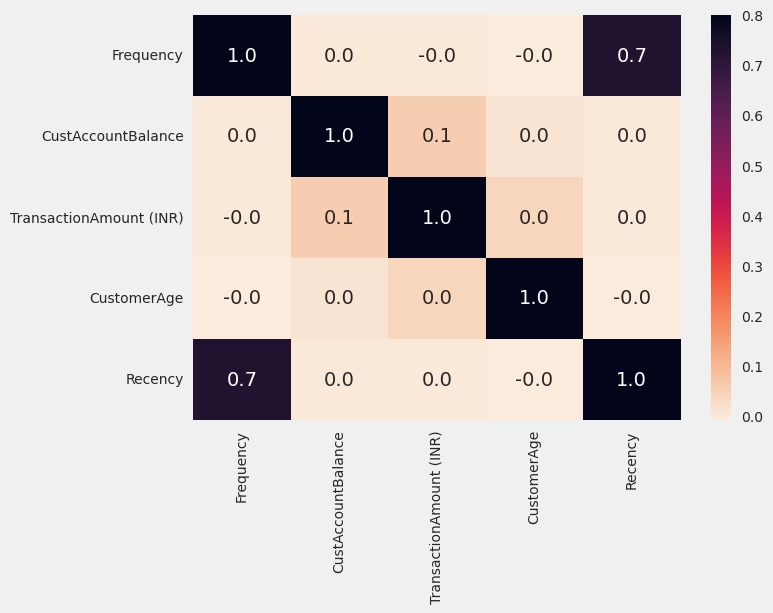

In [29]:
# correlation between features
plt.figure(figsize=(7,5))
correlation=MRF_df.corr()
sns.heatmap(correlation,vmin=None,
    vmax=0.8,
    cmap='rocket_r',
    annot=True,
    fmt='.1f',
    linecolor='white',
    cbar=True);

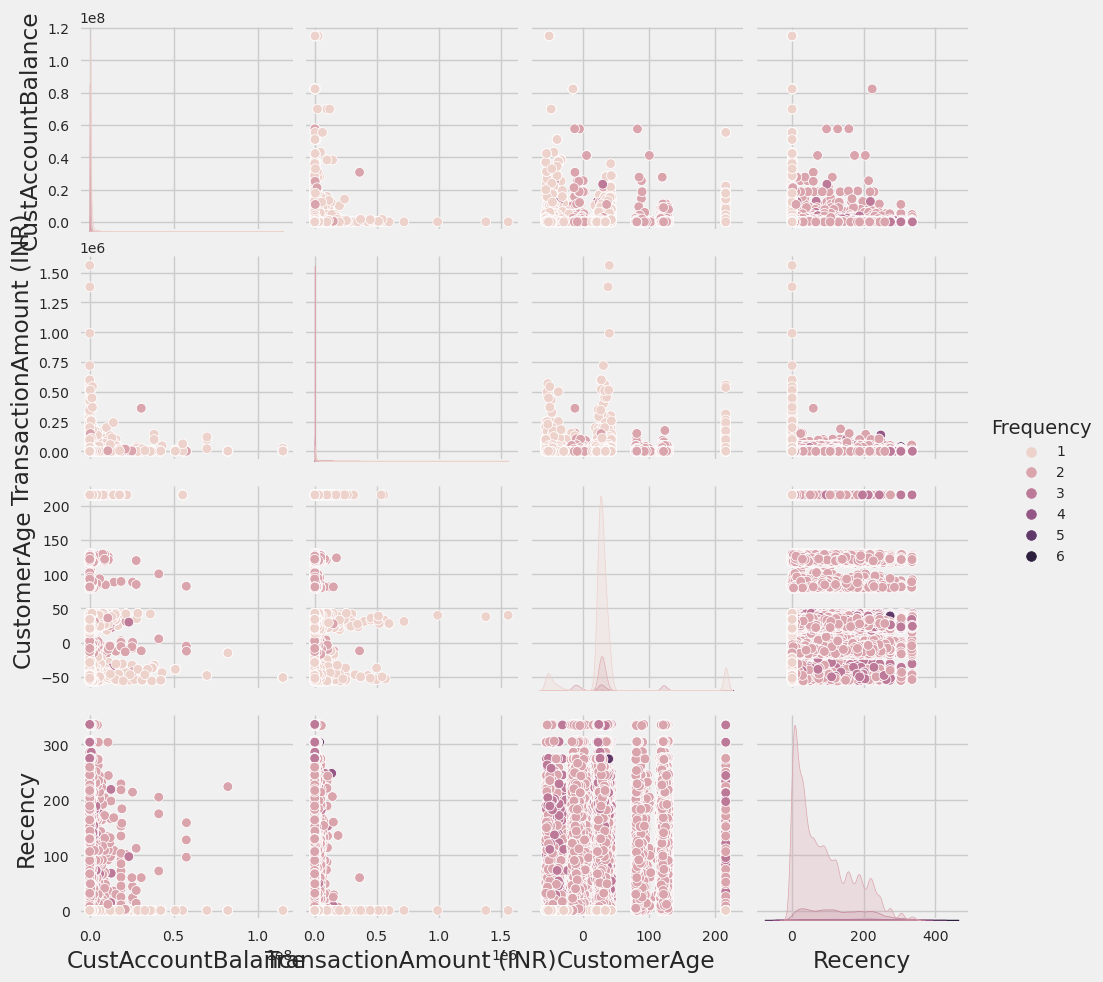

In [30]:
plt.style.use("fivethirtyeight")
sns.pairplot(MRF_df,hue='Frequency');

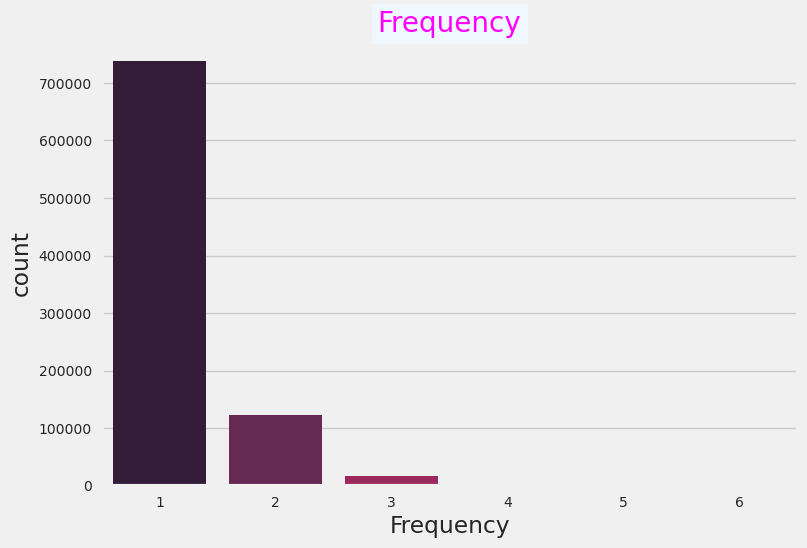

In [31]:
plt.style.use("fivethirtyeight")
chart=sns.countplot(x='Frequency',data=MRF_df,palette='rocket', order = MRF_df['Frequency'].value_counts().index)
plt.title("Frequency",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta');


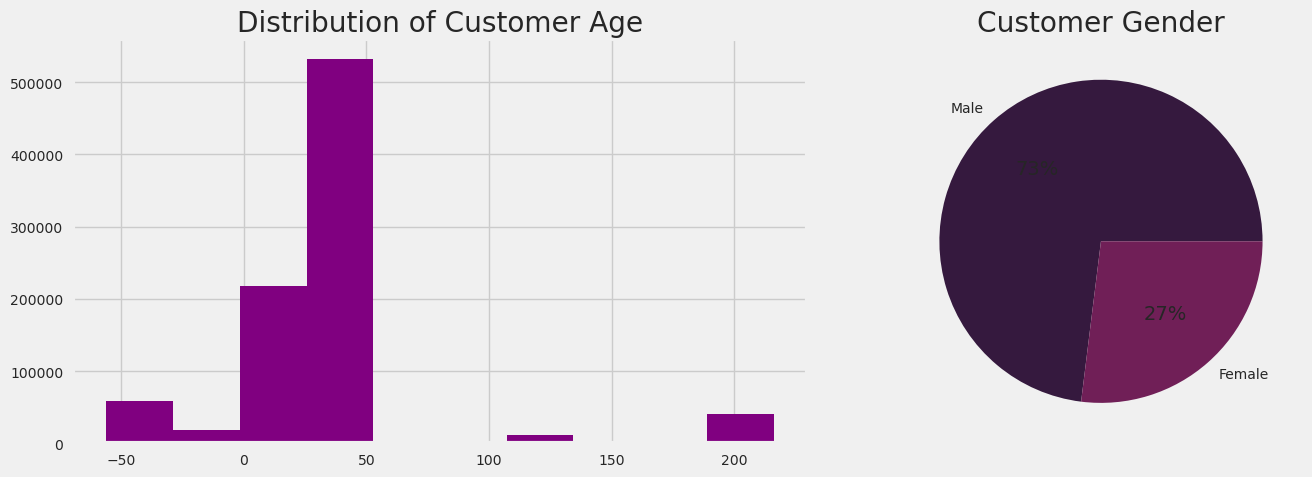

In [32]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
palette_color = sns.color_palette('rocket')
ax[0].hist(x=MRF_df['CustomerAge'],color='purple')
ax[0].set_title("Distribution of Customer Age")
ax[1].pie(MRF_df['CustGender'].value_counts(),autopct='%1.f%%',colors=palette_color,labels=['Male','Female'])
ax[1].set_title("Customer Gender")
plt.tight_layout();

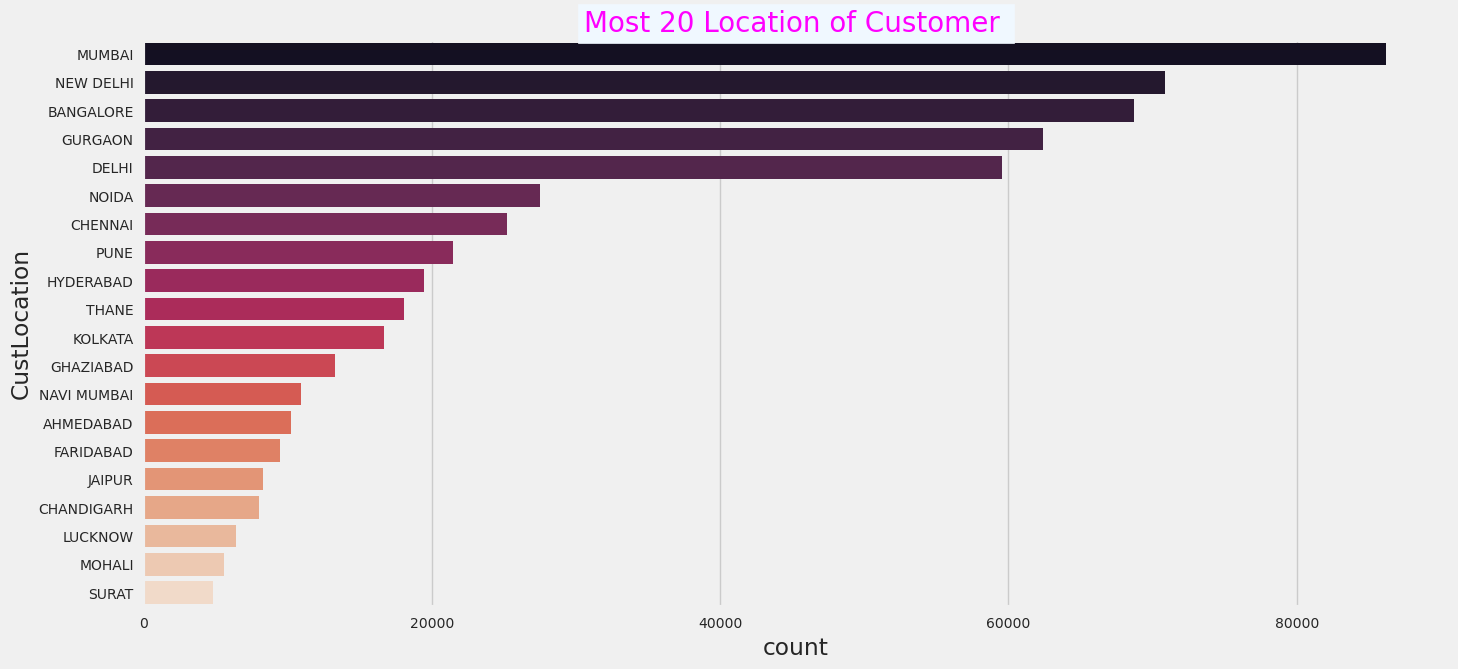

In [33]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,7))
chart=sns.countplot(y='CustLocation',data=MRF_df,palette='rocket', order = MRF_df['CustLocation'].value_counts()[:20].index)
plt.title("Most 20 Location of Customer ",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta');

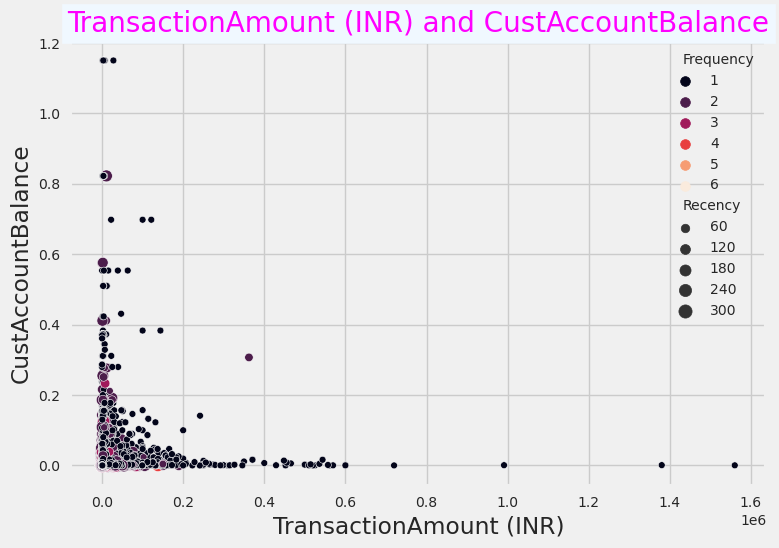

In [34]:
plt.style.use("fivethirtyeight")
sns.scatterplot(x='TransactionAmount (INR)',y='CustAccountBalance',data=MRF_df,palette='rocket',hue='Frequency',size='Recency' )
plt.title("TransactionAmount (INR) and CustAccountBalance",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta');

In [35]:
# difference between maximum and minimum date
MRF_df['TransactionDate'].max()-MRF_df['TransactionDate'].min()

Timedelta('336 days 00:00:00')

In [36]:
MRF_df=MRF_df.sort_values(by='TransactionDate')
groupbby_month=MRF_df.groupby([pd.Grouper(key='TransactionDate',freq='M')]).mean()
print(groupbby_month.shape)
groupbby_month

(12, 5)


,Frequency,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency
TransactionDate,,,,,
2016-01-31,1.025196,107508.805797,1448.714678,33.117387,1.918747
2016-02-29,1.064317,105680.497569,1502.272034,33.397089,5.091711
2016-03-31,1.091612,111479.999592,1643.042085,32.519724,8.617264
2016-04-30,1.172430,114318.492265,1691.246723,31.694946,25.188155
2016-05-31,1.355424,109561.572298,1592.128640,32.489199,62.542281
2016-06-30,1.359702,109571.765181,1658.123285,32.300006,53.389229
2016-07-31,1.354797,106349.124901,1573.295768,31.827322,37.011021
2016-08-31,1.158752,120503.189601,1569.334883,33.157626,7.485432
2016-09-30,1.211712,117934.764734,1530.263571,33.446020,10.531790


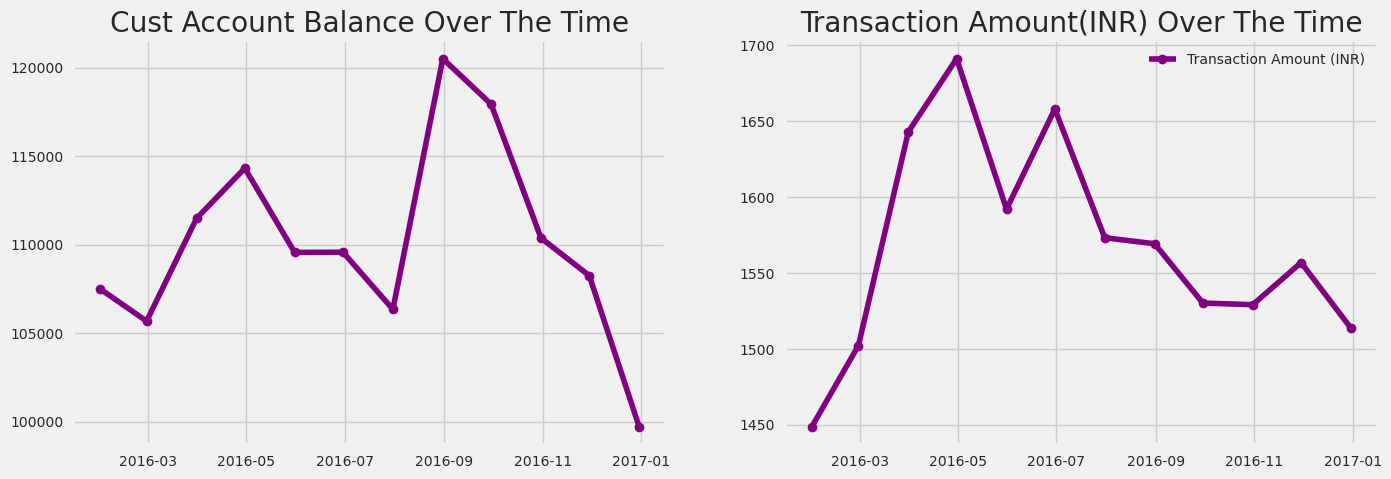

In [37]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
ax[0].plot(groupbby_month.index,groupbby_month['CustAccountBalance'],color='purple',marker='o',label='Customer Account Balance')
ax[0].set_title('Cust Account Balance Over The Time')
ax[1].plot(groupbby_month.index,groupbby_month['TransactionAmount (INR)'],color='purple',marker='o',label='Transaction Amount (INR)')
ax[1].set_title("Transaction Amount(INR) Over The Time")
plt.legend();

<h2  style="color:darkmagenta;text-align: center; background-color: AliceBlue;padding: 20px;">5. Feature Engineering </h2><a id = "5"></a>

In [38]:
MRF_df=MRF_df.reset_index(drop=True)

In [39]:
MRF_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate,Recency
0,1,F,AHMEDABAD,703891.99,2000.00,29.0,2016-01-08,1
1,1,M,MUMBAI,156310.08,1347.90,-51.0,2016-01-08,1
2,1,M,OPP SAI BABA TEMPLE HYDERABAD,95792.79,9900.00,216.0,2016-01-08,1
3,1,M,DELHI,1753.41,154.05,27.0,2016-01-08,1
4,1,M,DELHI,39579.53,194.00,30.0,2016-01-08,1


In [40]:
MRF_df.drop(columns=['CustLocation','TransactionDate'],inplace=True)

In [41]:
MRF_df['CustGender']=MRF_df['CustGender'].map({'M':1,'F':0})

In [42]:
# data scaling
df_scaled=StandardScaler().fit_transform(MRF_df)
df_scaled=pd.DataFrame(df_scaled,columns=MRF_df.columns)
df_scaled.head()

,Frequency,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency
0,-0.410992,-1.645853,0.735475,0.067345,-0.083051,-0.318862
1,-0.410992,0.607588,0.051923,-0.034020,-1.799437,-0.318862
2,-0.410992,0.607588,-0.023621,1.295357,3.929002,-0.318862
3,-0.410992,0.607588,-0.141011,-0.219598,-0.125960,-0.318862
4,-0.410992,0.607588,-0.093792,-0.213388,-0.061596,-0.318862


<p>the data is very very big so I will use only 100000 rows </p>

In [43]:
df_scaled=df_scaled.sample(n=100000,random_state=42).reset_index(drop=True)
df_scaled.head()

,Frequency,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency
0,1.816407,-1.645853,-0.112481,-0.197377,-0.115233,0.195565
1,1.816407,-1.645853,-0.096483,-0.234310,0.024223,0.538516
2,-0.410992,0.607588,-0.141308,-0.212455,-0.083051,-0.318862
3,1.816407,-1.645853,-0.045140,-0.227222,1.901521,0.195565
4,-0.410992,0.607588,-0.126809,-0.159915,-0.147415,-0.318862


<h2  style="color:darkmagenta;text-align: center; background-color: AliceBlue;padding: 20px;">6. Modelling </h2><a id = "6"></a>

<h3 style="color:darkmagenta; font-family:Cursive">K-mean</h3> 

<p style="font-size:14px; color:black; font-weight:bold; font-style:italic;">
The<span style="color: darkmagenta"> k-means</span>
 clustering is a method of vector quantization, originally from signal processing, that</p>

<p style="font-size:14px; color:black; font-weight:bold; font-style:italic;">
The<span style="color: darkmagenta"> Elbow</span>
method is a graphical representation of finding the optimal 'K' in a K-means cluste  </p>

<p style="font-size:14px; color:black; font-weight:bold; font-style:italic;">
The<span style="color: darkmagenta"> Silhouette Coefficient</span>
 or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1. 1: Means clusters are well apart from each other and clearly distinguished  </p>
 
<p style="font-size:14px; color:black; font-weight:bold; font-style:italic;">
The<span style="color: darkmagenta"> Dendrogram</span>
 is a diagram that shows the hierarchical relationship between objects. It is most commonly created as an output from hierarchical clustering </p>



I recommend you this video to understand what elbow and silhouette <a href="https://youtu.be/AtxQ0rvdQIA">Number of Clusters as a Hyperparameter The Elbow and Silhouette Method</a>

<img src="https://miro.medium.com/max/1200/1*rw8IUza1dbffBhiA4i0GNQ.png" alt="k-mean" >

In [44]:
# Kmeans algorithm settings
kmeans_set = {"init":"random", "max_iter":300, "random_state":42}

inertias = []
silhouette_coefficients = []

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, **kmeans_set)    # open dictionary
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)
    score=silhouette_score(df_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)
    

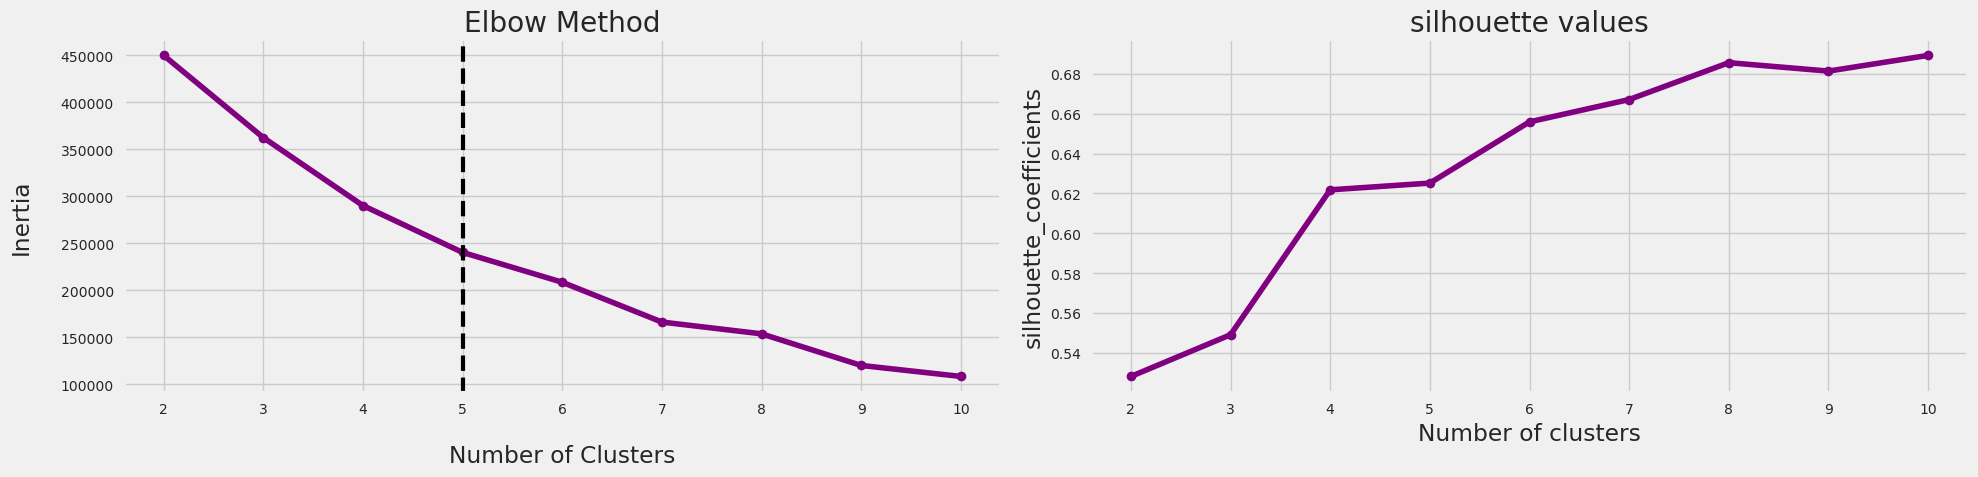

In [45]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(1,2,figsize=(20,5))
kl = KneeLocator(range(2,11), inertias, curve='convex', direction="decreasing")
ax[0].plot(range(2,11), inertias,color='purple',marker='o',label='Elbow Method')
ax[0].set_xticks(range(2,11))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("Inertia", labelpad=20)
ax[0].set_title("Elbow Method")
ax[0].axvline(x=kl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)

ax[1].plot(range(2,11), silhouette_coefficients,color='purple',marker='o',label='silhouette coefficients')
ax[1].set_xticks(range(2,11))
ax[1].set_title("silhouette values")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("silhouette_coefficients")
plt.tight_layout();

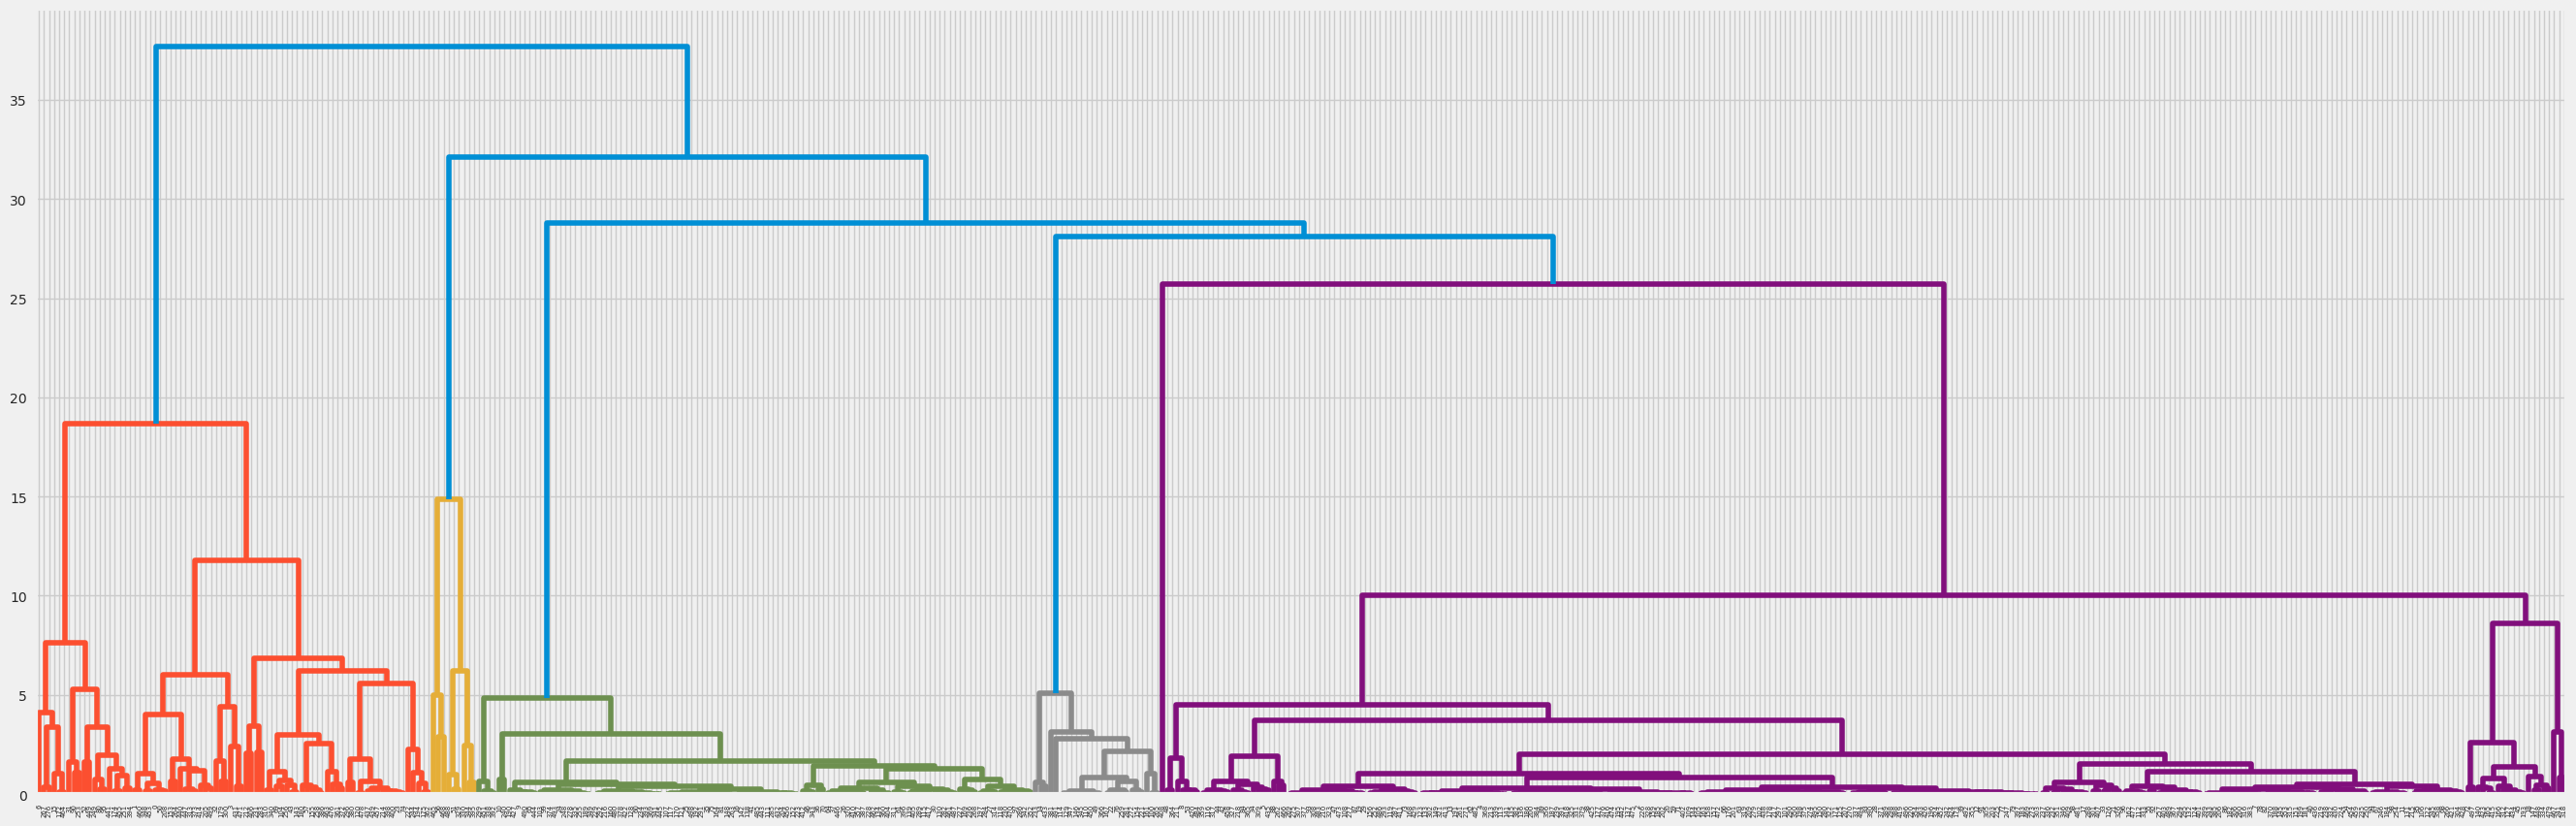

In [46]:
plt.figure(figsize=(30,10))
z = sch.linkage(df_scaled.iloc[:500,:], 'ward')
sch.dendrogram(z);

<p>the three charts insure that the number of clustering is 5 so I will use it</p>

In [47]:
kmeans = KMeans(n_clusters=5 , **kmeans_set)    
kmeans.fit(df_scaled)
df_scaled['Label']=kmeans.labels_
df_scaled.head()

,Frequency,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency,Label
0,1.816407,-1.645853,-0.112481,-0.197377,-0.115233,0.195565,3
1,1.816407,-1.645853,-0.096483,-0.234310,0.024223,0.538516,3
2,-0.410992,0.607588,-0.141308,-0.212455,-0.083051,-0.318862,4
3,1.816407,-1.645853,-0.045140,-0.227222,1.901521,0.195565,3
4,-0.410992,0.607588,-0.126809,-0.159915,-0.147415,-0.318862,4


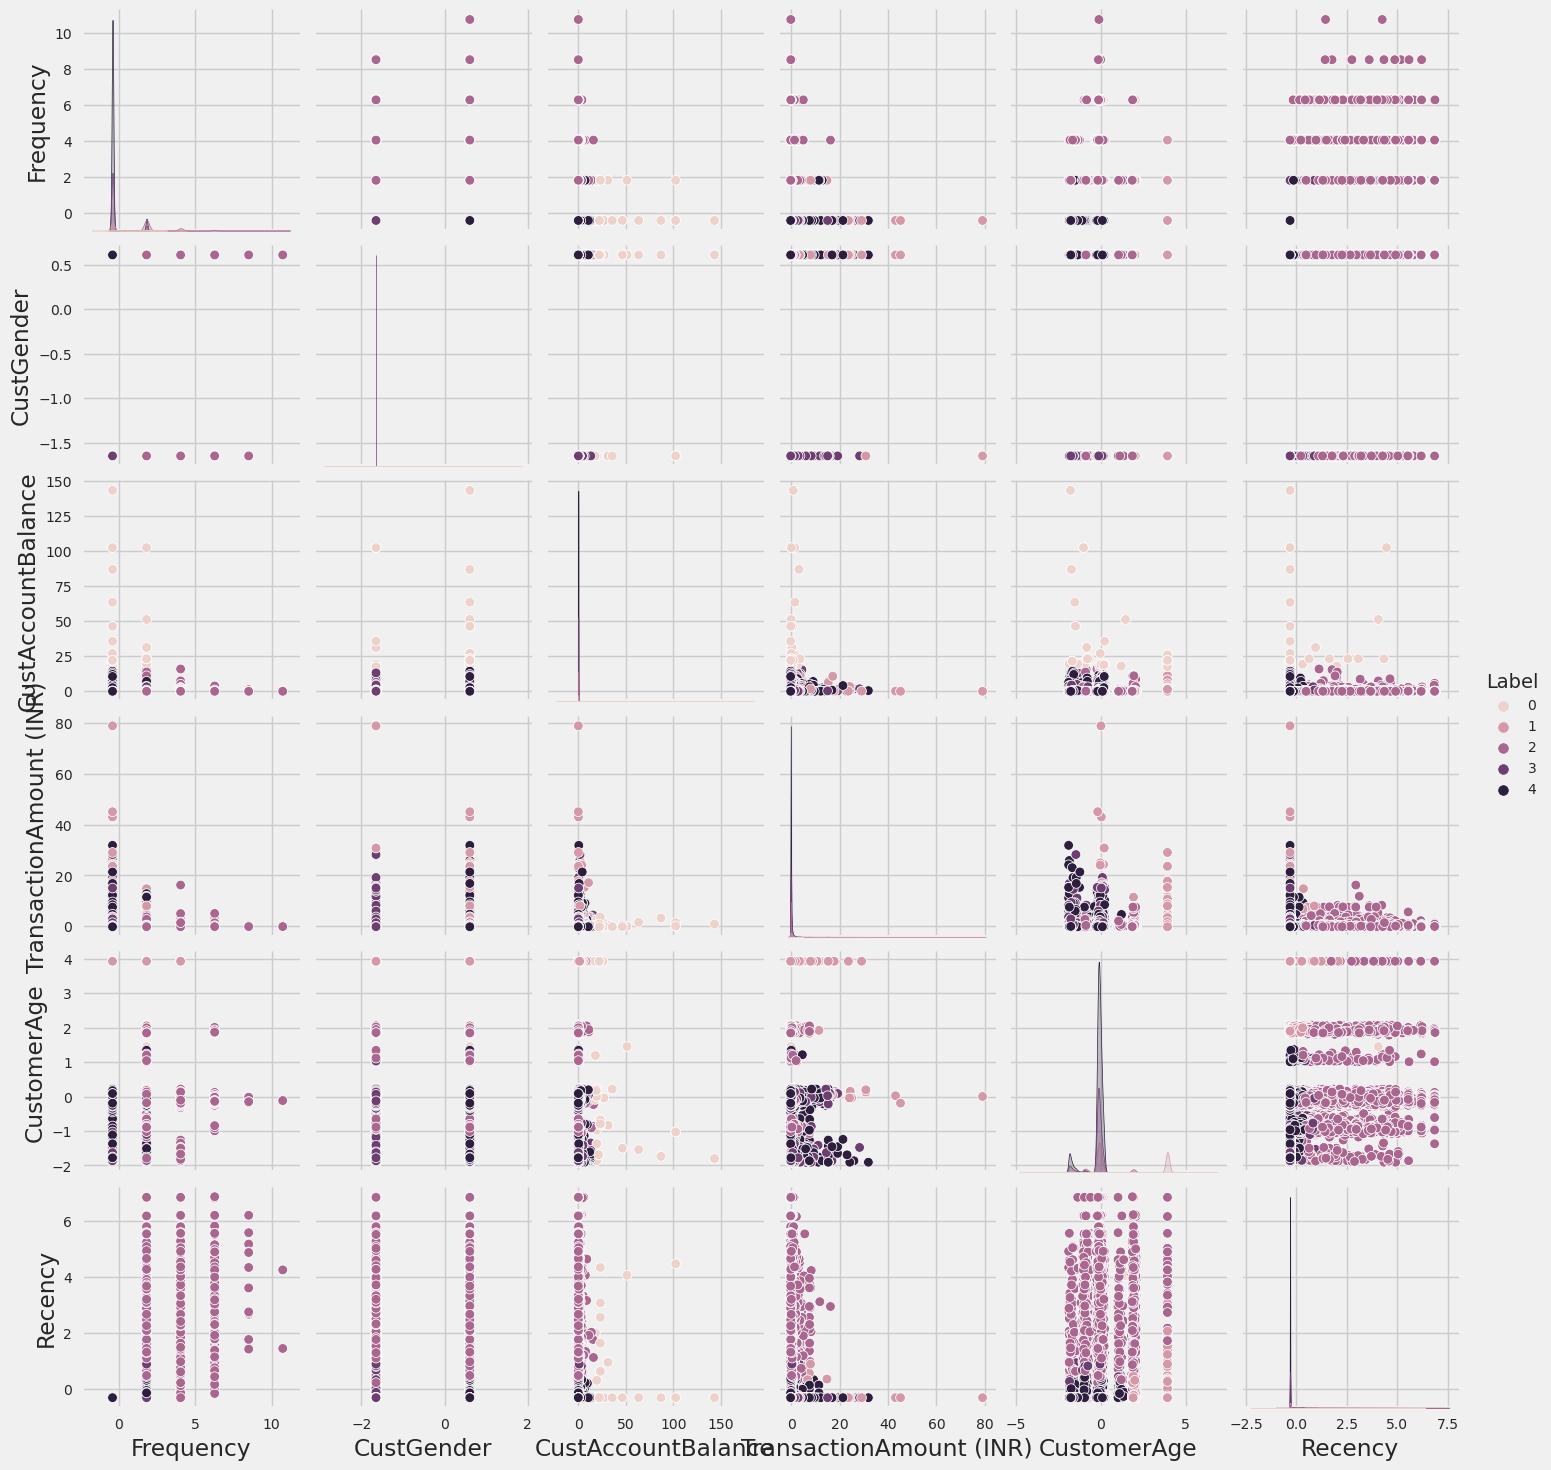

In [48]:
sns.pairplot(df_scaled,hue='Label');

In [49]:
attributes = df_scaled.columns[:6]
colors=['purple','yellow','red','blue','magenta','orange']
cluster=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6']

fig = go.Figure()
for index in range(0,6):
    fig.add_trace(go.Scatterpolar(r=np.mean(df_scaled.loc[df_scaled.Label == index, attributes]),
                                  theta=attributes,
                                  fill='toself',
                                  fillcolor=colors[index],
                                  opacity=0.4,
                                  name=cluster[index]))
    
fig.update_layout(polar=dict(radialaxis=dict(visible=True)),showlegend=True,
                  title="Radar plot - Cluster attributes (Normalized Values)")
fig.show()

<p>cluster1 : has customers with high TransactionAmount (INR) and CustAccountBalance but the other columns are the same</p>
<p>cluster2 : has customers with high Frequencyt and Recency but the other columns are the same</p>
<p>cluster5 : has customers with high CustomerAge but the other columns are the same</p>
<p>cluster3,cluster4 and cluster6 are the same</p>


<p></p>

<h3 style="color:darkmagenta; font-family:Cursive">PCA</h3> 

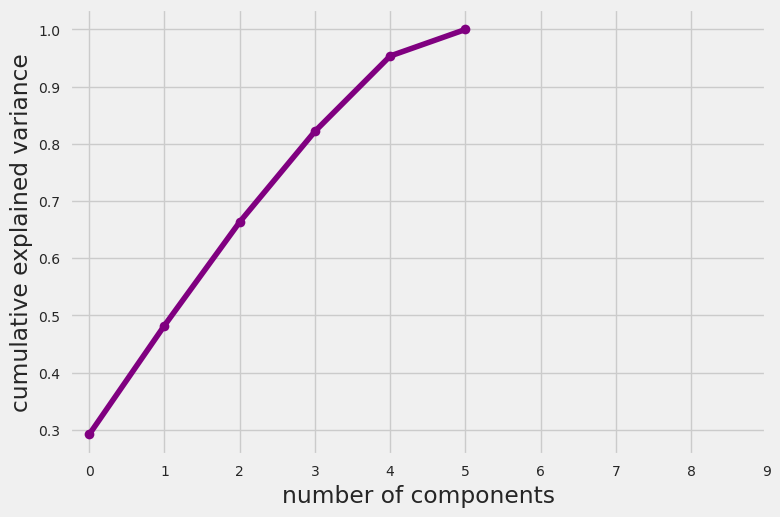

In [50]:
# here we want to check how many component we need to explain 90%  of the variance
plt.style.use("fivethirtyeight")
pca = PCA().fit(df_scaled.iloc[:,:-1])
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='purple',marker='o')  #EX: cusum([4,2,3,1,6]) ==>[4,6,9,10,16]
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
# x tickes
plt.xticks(np.arange(0, 10, 1))
plt.show();

In [51]:
pca = PCA(n_components=4)
pca_data = pca.fit_transform(df_scaled.iloc[:,:-1])

inertia = []
silhouette = []


for k in range(2,11):
    km = KMeans(init='k-means++', n_clusters=k, random_state=42)
    km.fit(pca_data)
    inertia.append(km.inertia_)
    P_score=silhouette_score(pca_data, km.labels_)
    silhouette.append(P_score)

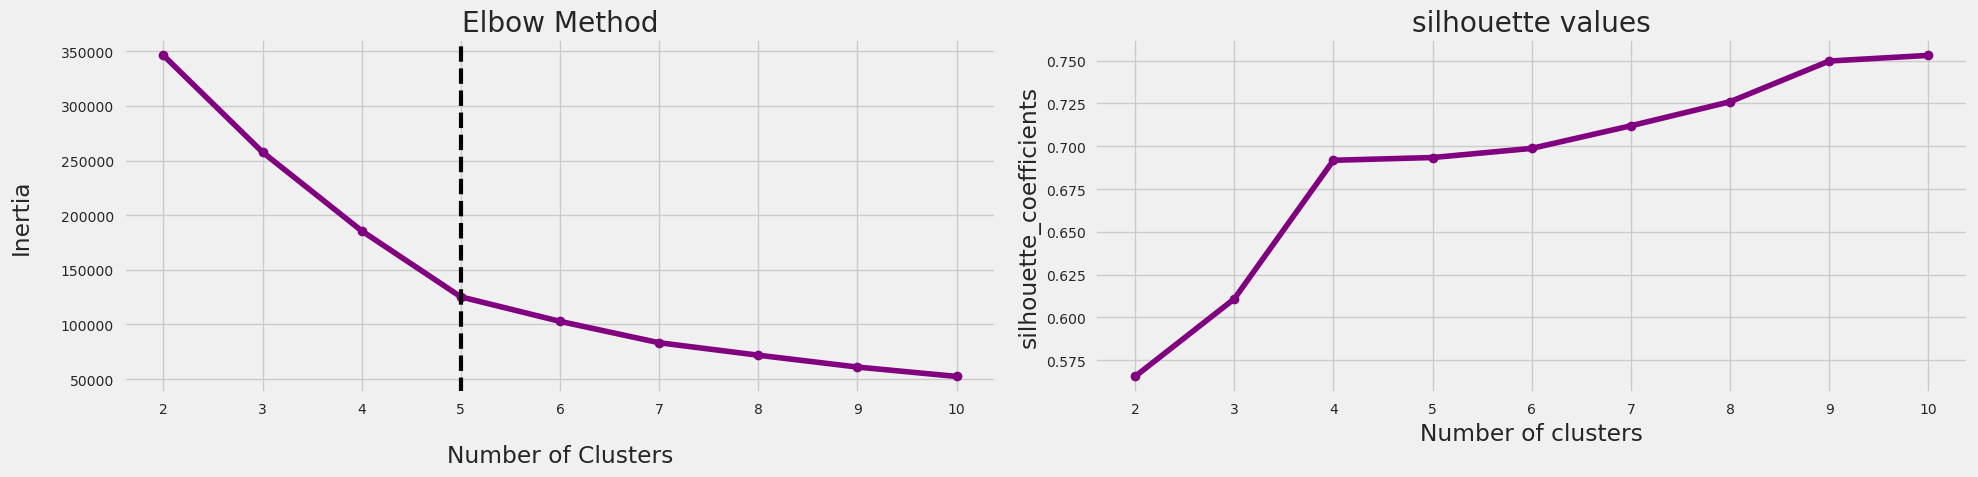

In [52]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(1,2,figsize=(20,5))
Pkl = KneeLocator(range(2,11), inertia, curve='convex', direction="decreasing")
# draw Elbow
ax[0].plot(range(2,11), inertia,color='purple',marker='o',label='Elbow Method')
ax[0].set_xticks(range(2,11))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("Inertia", labelpad=20)
ax[0].set_title("Elbow Method")
ax[0].axvline(x=Pkl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)
# draw silhouette
ax[1].plot(range(2,11), silhouette,color='purple',marker='o',label='silhouette coefficients')
ax[1].set_xticks(range(2,11))
ax[1].set_title("silhouette values")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("silhouette_coefficients")
plt.tight_layout();

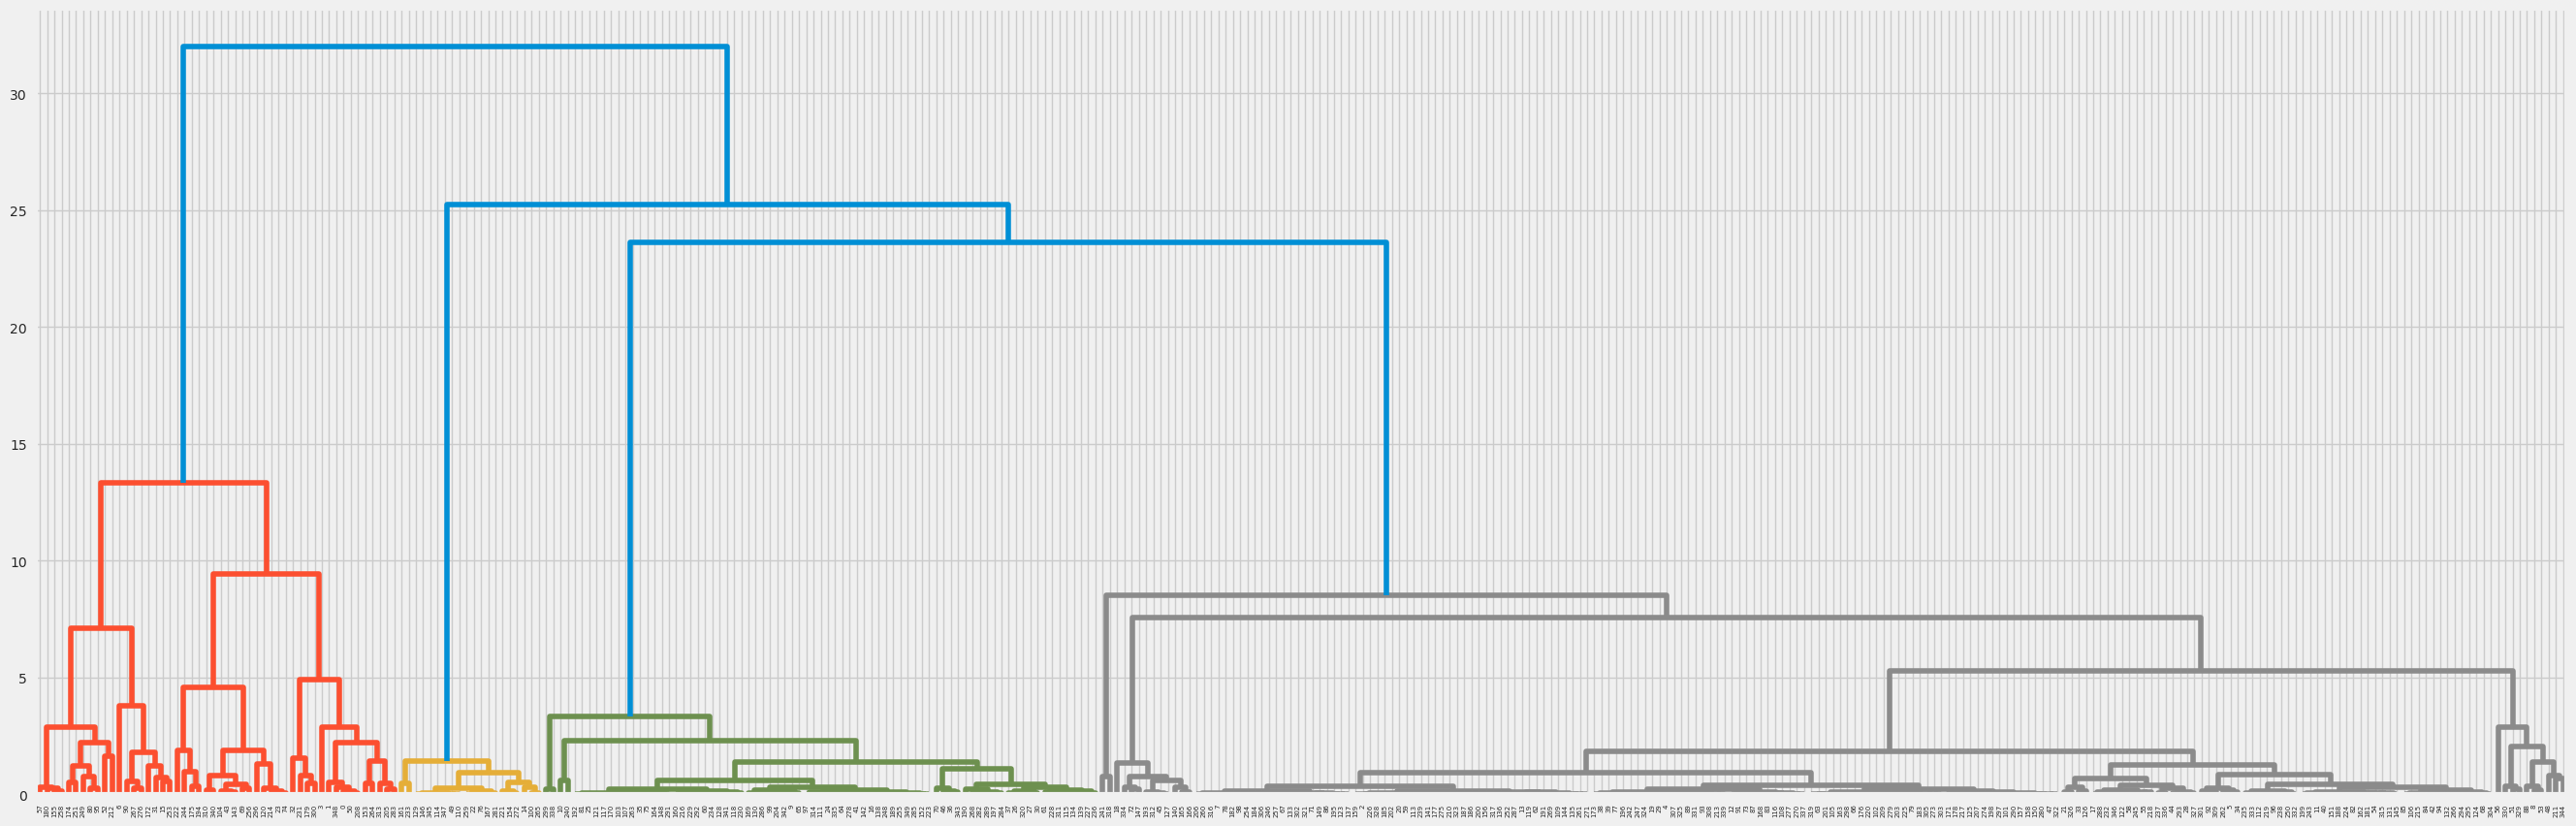

In [53]:
plt.figure(figsize=(30,10))
z = sch.linkage(pca_data[:350,:], 'ward')
sch.dendrogram(z);

<p>the three charts insure that the number of clustering is 5 so I will use it</p>

In [54]:
PCA_kmeans = KMeans(n_clusters=5 , **kmeans_set)    
PCA_kmeans.fit(pca_data)
# create a dataframe for the pca data
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df['label'] = PCA_kmeans.labels_
pca_df.head()

,PC1,PC2,PC3,PC4,label
0,1.424950,-0.393741,1.174090,-1.087977,3
1,1.665703,-0.353948,1.082099,-1.176258,3
2,-0.512828,-0.111816,-0.386494,0.516700,4
3,1.411501,0.134389,-0.180861,-2.431874,3
4,-0.512442,-0.103873,-0.340154,0.552729,4


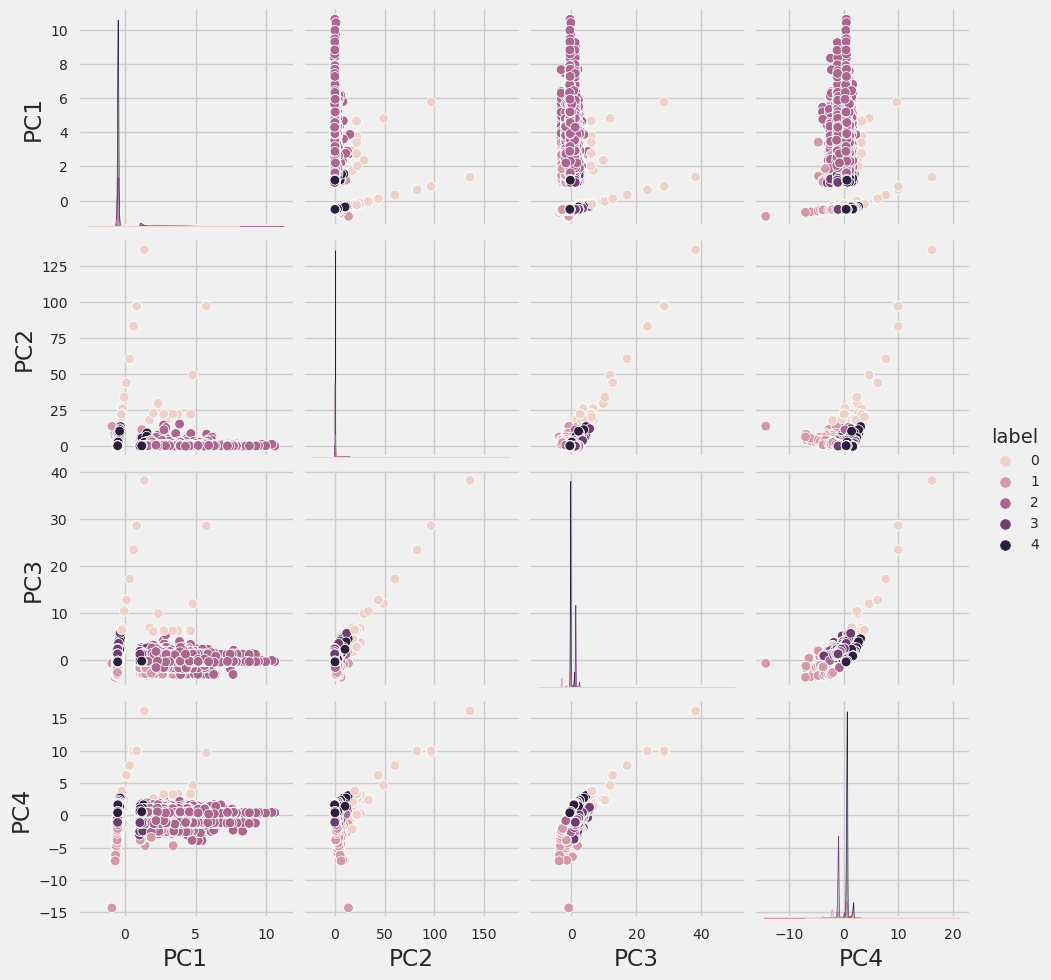

In [55]:
sns.pairplot(pca_df,hue='label');

In [56]:
attributes = pca_df.columns[:4]
colors=['purple','yellow','red','blue']
cluster=['Cluster 1','Cluster 2','Cluster 3','Cluster 4']

fig = go.Figure()
for index in range(0,4):
    fig.add_trace(go.Scatterpolar(r=np.mean(pca_df.loc[pca_df.label == index, attributes]),
                                  theta=attributes,
                                  fill='toself',
                                  fillcolor=colors[index],
                                  opacity=0.4,
                                  name=cluster[index]))
    
fig.update_layout(polar=dict(radialaxis=dict(visible=True)),showlegend=True,
                  title="Radar plot - Cluster attributes (Normalized Values)")
fig.show()

<p>cluster1 : has customers with high PC3 and PC4 but the other columns are the same</p>
<p>cluster2 : has customers with high PC2 but the other columns are the same</p>
<p>cluster3 and cluster4 are the same</p>

<p></p>

<p style="color:MediumVioletRed; font-family:Cursive"><b>thank you for reading to the end, your advice and comments are important to me. Don't forget to upvote this notebook if you like it! ❤️</p>